# Fraud Detection – Exploratory Data Analysis & Feature Engineering

This notebook covers the exploratory data analysis (EDA), fraud pattern discovery,
and feature engineering steps for a synthetic financial transaction dataset.
The objective is to understand transaction behavior, identify non-random fraud patterns,
and engineer meaningful features for downstream machine learning models.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

df = pd.read_csv("data/raw/transactions_raw.csv")


In [4]:
df.shape


(6362620, 11)

## 1. Data Loading and Initial Sanity Checks

In this section, we load the synthetic transaction dataset and perform basic
sanity checks such as dataset shape, column data types, missing values, and
class imbalance. This helps ensure data quality and suitability for fraud detection.


In [5]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [6]:
df.isnull().sum()


step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

## 2. Dataset Overview and Fraud Distribution

Fraud detection datasets are typically highly imbalanced. In this section,
we analyze the distribution of fraudulent and non-fraudulent transactions
to understand the severity of class imbalance and its implications for modeling.


In [7]:
df['isFraud'].value_counts()


isFraud
0    6354407
1       8213
Name: count, dtype: int64

In [8]:
df['isFraud'].value_counts(normalize=True)


isFraud
0    0.998709
1    0.001291
Name: proportion, dtype: float64

## 3. Exploratory Data Analysis (EDA)

This section explores transaction characteristics such as transaction types,
amount distributions, and behavioral differences between fraudulent and
legitimate transactions using visualizations.


### 3.1 Transaction Type Analysis

Different transaction types may carry different fraud risks.
Here, we analyze the frequency and fraud rate across transaction types.


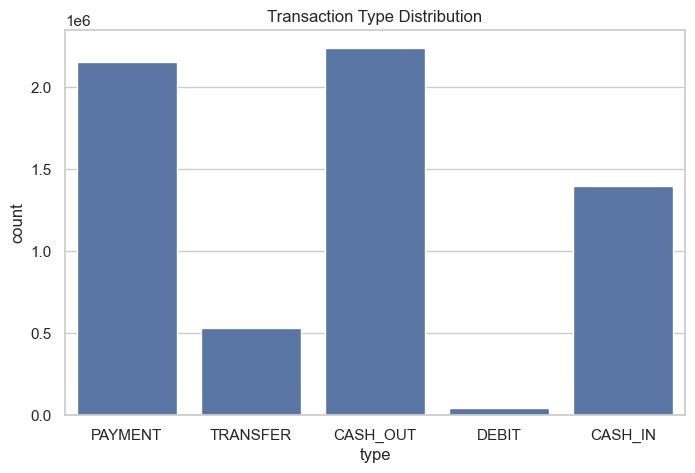

In [9]:
plt.figure(figsize=(8,5))
sns.countplot(data=df, x='type')
plt.title("Transaction Type Distribution")
plt.show()


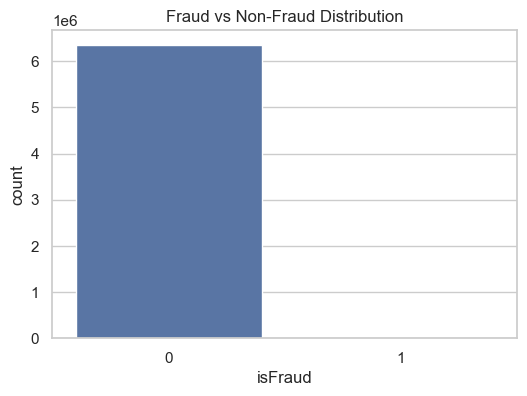

In [10]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='isFraud')
plt.title("Fraud vs Non-Fraud Distribution")
plt.show()


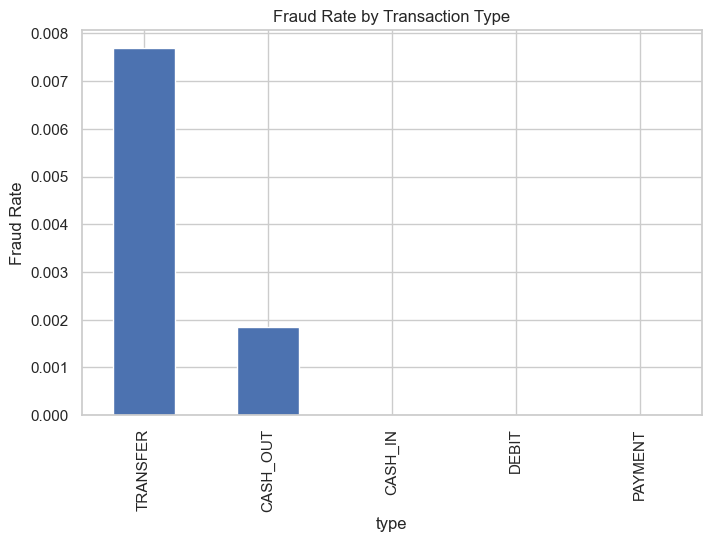

In [11]:
fraud_by_type = df.groupby('type')['isFraud'].mean().sort_values(ascending=False)

plt.figure(figsize=(8,5))
fraud_by_type.plot(kind='bar')
plt.ylabel("Fraud Rate")
plt.title("Fraud Rate by Transaction Type")
plt.show()


In [13]:
df.columns



Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

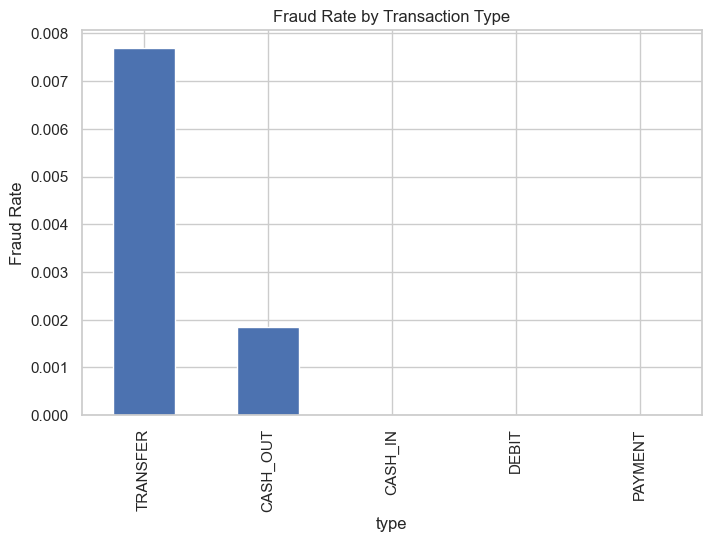

In [14]:
fraud_by_type = (
    df.groupby('type')['isFraud']
    .mean()
    .sort_values(ascending=False)
)

plt.figure(figsize=(8,5))
fraud_by_type.plot(kind='bar')
plt.ylabel("Fraud Rate")
plt.title("Fraud Rate by Transaction Type")
plt.show()


In [15]:
fraud_zero_balance = df[
    (df['isFraud'] == 1) & (df['newbalanceOrig'] == 0)
].shape[0]

fraud_total = df[df['isFraud'] == 1].shape[0]

fraud_zero_balance / fraud_total


0.9805186898818946

In [16]:
df['isFlaggedFraud'].value_counts()


isFlaggedFraud
0    6362604
1         16
Name: count, dtype: int64

### 3.2 Transaction Amount Analysis

This subsection analyzes transaction amount distributions for fraudulent
and non-fraudulent transactions. Log scaling is used due to the presence
of extreme values.


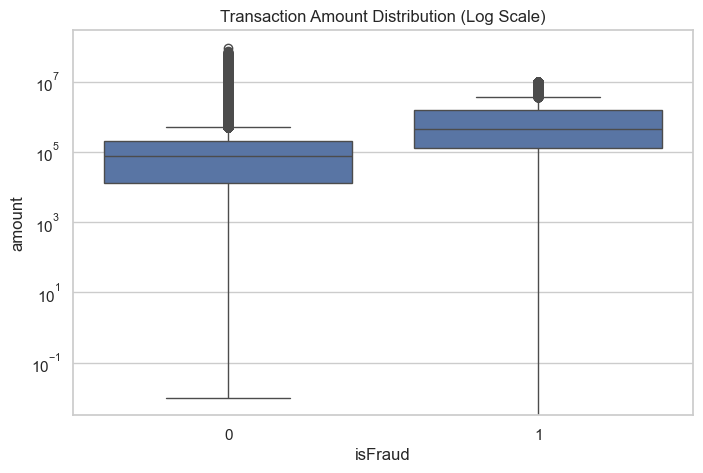

In [17]:
plt.figure(figsize=(8,5))
sns.boxplot(data=df, x='isFraud', y='amount')
plt.yscale('log')
plt.title("Transaction Amount Distribution (Log Scale)")
plt.show()


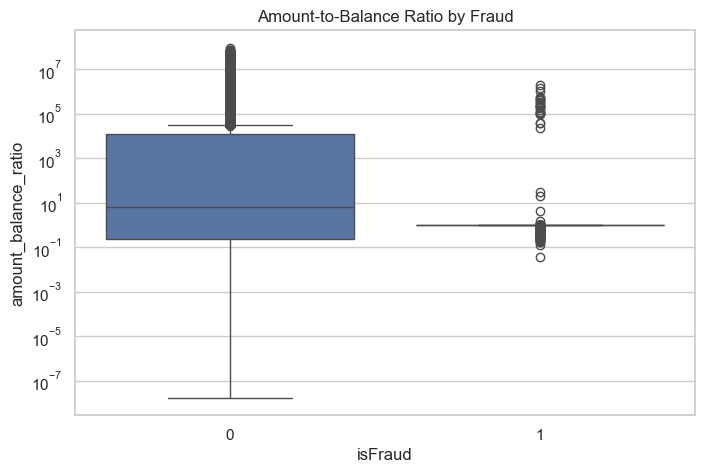

In [18]:
df['amount_balance_ratio'] = df['amount'] / (df['oldbalanceOrg'] + 1)

plt.figure(figsize=(8,5))
sns.boxplot(data=df, x='isFraud', y='amount_balance_ratio')
plt.yscale('log')
plt.title("Amount-to-Balance Ratio by Fraud")
plt.show()


In [19]:
df_fe = df.drop(['nameOrig', 'nameDest'], axis=1)


In [20]:
df_fe = pd.get_dummies(df_fe, columns=['type'], drop_first=True)


In [21]:
df_fe['orig_balance_diff'] = (
    df_fe['oldbalanceOrg'] - df_fe['newbalanceOrig']
)

df_fe['dest_balance_diff'] = (
    df_fe['newbalanceDest'] - df_fe['oldbalanceDest']
)


In [22]:
df_fe['amount_balance_ratio'] = (
    df_fe['amount'] / (df_fe['oldbalanceOrg'] + 1)
)

df_fe['zero_balance_after'] = (
    df_fe['newbalanceOrig'] == 0
).astype(int)

df_fe['large_amount_flag'] = (
    df_fe['amount'] > df_fe['amount'].quantile(0.99)
).astype(int)


In [24]:
import os

os.makedirs("data/processed", exist_ok=True)


In [25]:
df_fe.to_csv(
    "data/processed/transactions_features.csv",
    index=False
)
